In [140]:
import pandas as pd
import re
import string
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import scikitplot.plotters as skplt
import nltk
import seaborn as sns
import scipy
import nltk

from nltk.stem.porter import *  
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords
%matplotlib inline
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\scojo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\scojo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [141]:
 def var_clean(var_file)  :
    tr_var = pd.read_csv(var_file)
    tr_vardf = pd.DataFrame(tr_var)
    tr_vardf['Variation'] = tr_vardf['Variation'].str.upper()    
    

    tr_vardf['Mutations'] = np.where(tr_vardf['Variation'].str.contains('DELINS'),'Del/Ins',
                            np.where(tr_vardf['Variation'].str.contains('DEL'),'Deletion',
                            np.where(tr_vardf['Variation'].str.contains('INS'),'Insertion',
                            np.where(tr_vardf['Variation'].str.contains('EXON'),'Exon Mutations',
                            np.where(tr_vardf['Variation'].str.contains('PROM'),'Promotor Mutation',
                            np.where(tr_vardf['Variation'].str.contains('FS'),'Frameshift',
                            np.where(tr_vardf['Variation'].str.contains('FUS'),'Fusion',
                            np.where(tr_vardf['Variation'].str.contains('AMPL'),'Amplification',
                            np.where(tr_vardf['Variation'].str.contains('SPLI'),'Splice',
                            np.where(tr_vardf['Variation'].str.contains('OVEREXPRE'),'Overexpression',
                            np.where(tr_vardf['Variation'].str.contains('DU'),'Duplication',
                            np.where(tr_vardf['Variation'].str.contains('COPY'),'Copy Number',
                            np.where(tr_vardf['Variation'].str.contains('HYPERM'),'Hypermethylation',
                            np.where(tr_vardf['Variation'].str.contains('TRUN'),'Truncation','Other')))))))))))))) 
    
#     creates snp location column
    tr_vardf['SNP location'] = np.where(tr_vardf['Mutations']=='Other',tr_vardf['Variation'].str[1:-1], np.nan)
#  if location is not numer ic it becomes NaN
    tr_vardf['SNP location'] = pd.to_numeric(tr_vardf['SNP location'], errors = 'coerce', downcast = 'integer')

#  if snp location is not null and mutation = other, start aa is created and spliced from variation
    tr_vardf['Start aa'] = np.where(np.logical_and(tr_vardf['Mutations']=='Other',tr_vardf['SNP location'].notnull()) ,tr_vardf['Variation'].str[0:1], np.nan)
#  if snp location is not null and mutation = other, start aa is created and spliced from variation   
    tr_vardf['End aa'] = np.where(np.logical_and(tr_vardf['Mutations']=='Other',tr_vardf['SNP location'].notnull()),tr_vardf['Variation'].str[-1:],np.nan)
    
    # if there is an snp location for an other mutation it is set to SNP    
    tr_vardf['Mutations'] = np.where(np.logical_and(tr_vardf['Mutations']=='Other', tr_vardf['SNP location'].notnull()), 'SNP', tr_vardf['Mutations'])
# if the SNP mutation end in a stop codon * it is a nonsense mutation
    tr_vardf['Mutations'] = np.where(np.logical_and(tr_vardf['Mutations']=='SNP', tr_vardf['End aa']=='*'), 'Nonsense', tr_vardf['Mutations'])
        
    bins = [0,250, 500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500]
    tr_vardf['SNP bins'] = pd.cut(tr_vardf['SNP location'], bins)
    del tr_vardf['SNP location']
                                     
    del tr_vardf['Variation']
    return tr_vardf


In [142]:
def text_open(text_file):
    tr_text = pd.read_csv(text_file, sep= '\|\|', engine = 'python', header = None, skiprows =1, encoding = 'utf8', names = ['ID', 'Text'])
    tr_textdf = pd.DataFrame(tr_text)
    tr_textdf['Driver'] =np.where(tr_textdf['Text'].str.lower().str.contains('drive'), 1, 0)
    tr_textdf['Passenger'] =np.where(tr_textdf['Text'].str.lower().str.contains('passeng'), 1, 0)
    tr_textdf['Driver/Passenger'] = np.where(np.logical_and(tr_textdf['Driver']==1, tr_textdf['Passenger']==1), 1, 0)
    return tr_textdf

In [143]:
def text_var(var_file, text_file):
    text_var = pd.merge(var_file, text_file, on= 'ID', how = 'left').dropna(subset =['Text'])
    return text_var

In [144]:
def remove_dups(df):
    nodups = df.drop_duplicates(subset =['Gene', 'Class', 'Mutations', 'SNP bins','Start aa', 'End aa', 'Text'], keep = 'first')
    return nodups

In [145]:
def main():
    test_v = var_clean('./test_variants')
    train_v = var_clean('./training_variants')
    test_t = text_open('./test_text')
    train_t = text_open('./training_text')
    valid_t = text_open('./testing_text.txt')
    valid_v = var_clean('./testing_variants.txt')
    

# merge datasets into taining and validation files, remove rows with missing values
    train = remove_dups(text_var(train_v, train_t))
    
    test = text_var(test_v, test_t)
    valid = remove_dups(text_var(valid_v, valid_t))
    
#     train['Driver'] =np.where(train['Text'].str.lower().str.contains('drive'), 1, 0)
#     train['Passenger'] =np.where(train['Text'].str.lower().str.contains('passeng'), 1, 0)
    return train, valid, test

In [146]:
train, valid, test = main()

In [147]:

import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS
stemmer=PorterStemmer()
stopWords = ["fig", "figure", "et", "al", "table",  
        "data", "analysis", "analyze", "study",  
        "method", "result", "conclusion", "author", "mutation" ,
        "thus", "therefore", "fig", "figure", "page",
        "find", "found", "show", "perform",  "cell", "cells"
        "demonstrate", "evaluate", "discuss", "google", "scholar",   
        "pubmed",  "web", "science", "crossref", "supplementary", "..."] 
# stopWords = [stemmer.stem(word) for word in stopWords]

stop_words_new = stop_words.union(stopWords)

# token_pattern =r'(?u)\b\w\w\w\w+\b'

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()


In [148]:
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
#     mytokens = nltk.word_tokenize(sentence)
    

    
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    
#     mytokens = [stemmer.stem(str(word)) for word in mytokens ]
   
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words_new and word not in punctuations ]
    
    # Removing words less then 3 characters and numbers only tokens
    mytokens =[word for word in mytokens if len(word)>3 and bool(re.match(r"[0-9]{3,}", word)) is False]
    
    # return preprocessed list of tokens
    return mytokens

In [149]:
v = TfidfVectorizer(tokenizer = spacy_tokenizer, max_features = 1000)


xtfidf = v.fit_transform(train['Text'])
xtfidffeat = v.get_feature_names()

# Clean up data and select features

In [150]:
# convert tfidf back to dataframe
tfidf = pd.DataFrame(xtfidf.toarray(), columns=v.get_feature_names())

In [151]:
# remove test column
train2= train.drop('Text', axis = 1)

# remove outliers
train2 = train2.drop(train2[train2['End aa'] =='7'].index)
train2 = train2.drop(train2[train2['End aa'] =='5'].index)


In [152]:
# get dummy values for categorical data
train3= pd.get_dummies(train2, columns = ['Start aa', 'End aa', 'Mutations'])

In [153]:
# combine training set with tfidf set
traindf = pd.merge(train3, tfidf, left_index = True, right_index = True)
traindf.head()

,ID,Gene,Class,SNP bins,Driver,Passenger,Driver/Passenger,Start aa_A,Start aa_C,Start aa_D,...,weak,week,western,wide,wild,woman,work,xenograft,year,yeast
0,0,FAM58A,1,NaN,1,0,0,0,0,0,...,0.005318,0.0,0.069134,0.004810,0.008914,0.000000,0.008847,0.0,0.000000,0.019206
1,1,CBL,2,"(750.0, 1000.0]",0,0,0,0,0,0,...,0.000000,0.0,0.013016,0.000000,0.033288,0.019767,0.007079,0.0,0.021855,0.000000
2,2,CBL,2,"(0.0, 250.0]",0,0,0,0,0,0,...,0.000000,0.0,0.013016,0.000000,0.033288,0.019767,0.007079,0.0,0.021855,0.000000
3,3,CBL,3,"(250.0, 500.0]",1,1,1,0,0,0,...,0.000000,0.0,0.000000,0.016726,0.082659,0.000000,0.000000,0.0,0.015828,0.000000
4,4,CBL,4,"(250.0, 500.0]",1,1,1,0,0,0,...,0.015131,0.0,0.000000,0.006844,0.084551,0.000000,0.006294,0.0,0.006476,0.000000


In [154]:
# y values
ytrain = traindf['Class']

In [155]:
# split training data set into testing(33%) and training sets(67%)
X_Train, X_Test, y_Train, y_Test = train_test_split(traindf, ytrain, test_size=0.33, random_state=42)

In [156]:
# upsample training to balance classes
from imblearn.over_sampling import RandomOverSampler
sm = RandomOverSampler()
X_train, y_train = sm.fit_sample(X_Train, y_Train)

In [157]:
#  upsample testing to balance classes
from imblearn.over_sampling import RandomOverSampler
sm = RandomOverSampler()
X_test, y_test = sm.fit_sample(X_Test, y_Test)

In [158]:
# convert to dataframe
traincol= list(traindf.columns)
X_test = pd.DataFrame(X_test, columns = traincol)
y_test = pd.DataFrame(y_test)
X_train = pd.DataFrame(X_train, columns = traincol)
y_train = pd.DataFrame(y_train)

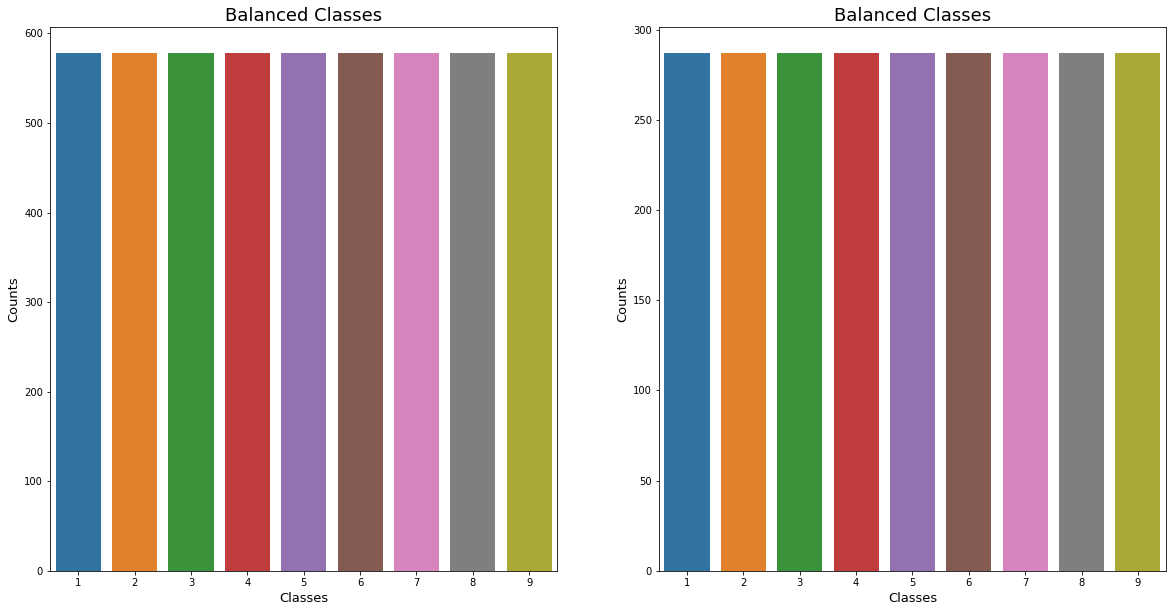

In [159]:
# plot balanced datasets
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.countplot(x="Class", data=X_train)
plt.ylabel('Counts', fontsize=13)
plt.xlabel('Classes', fontsize=13)
plt.title("Balanced Classes", fontsize=18)
plt.tight_layout

plt.subplot(1,2,2)
sns.countplot(x="Class", data=X_test)
plt.ylabel('Counts', fontsize=13)
plt.xlabel('Classes', fontsize=13)
plt.title("Balanced Classes", fontsize=18)
plt.tight_layout
plt.show()

In [160]:
# select features by removing gene, snp bins, passenger, driver/passenger columns
X_test = X_test.drop(axis = 1, columns =['Gene','SNP bins', 'Passenger','Driver/Passenger'])

In [161]:
X_test.head()

,ID,Class,Driver,Start aa_A,Start aa_C,Start aa_D,Start aa_E,Start aa_F,Start aa_G,Start aa_H,...,weak,week,western,wide,wild,woman,work,xenograft,year,yeast
0,63,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0.287461,0,0,0,0,0
1,2885,6,0,0,0,0,0,0,1,0,...,0.020228,0,0.0168758,0.00332687,0.0297992,0.00854245,0.010708,0,0.0377791,0
2,2098,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0153234,0,0,0,0.0293426,0.115553
3,348,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0407918,0,0.00759074,0,0.0937341,0
4,2848,6,0,0,0,0,0,0,0,0,...,0,0.0133253,0.0048694,0.0115194,0.00355795,0,0,0,0.0109009,0


In [162]:
# select features by removing gene, snp bins, passenger, driver/passenger columns
X_train = X_train.drop(axis = 1, columns =['Gene','SNP bins',  'Passenger','Driver/Passenger'])

In [163]:
X_train.head()

,ID,Class,Driver,Start aa_A,Start aa_C,Start aa_D,Start aa_E,Start aa_F,Start aa_G,Start aa_H,...,weak,week,western,wide,wild,woman,work,xenograft,year,yeast
0,1713,4,1,0,0,0,0,1,0,0,...,0,0,0.0511493,0.0100835,0.193097,0,0,0,0,0
1,891,3,1,0,0,0,0,0,1,0,...,0.00794447,0,0.0212645,0,0.00221964,0.00461315,0,0,0.00680057,0
2,2160,4,0,0,0,0,0,0,0,0,...,0,0.00536207,0.00391889,0,0.0372246,0,0,0,0,0
3,167,7,0,1,0,0,0,0,0,0,...,0,0,0,0,0.0604263,0.00627931,0,0,0.00462839,0
4,59,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0.0261128,0,0,0,0,0


# Creating a Stacked Model

In [332]:
# code adapted from https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/

def Stacking(model,train,y,test, n_fold):
    print(train.shape, y.shape, test.shape)
    folds=StratifiedKFold(n_splits=n_fold,random_state=1)
    test_pred=np.empty((test.shape[0],1),int)
    y_truth = np.empty((test.shape[0],1),int)
    print(test_pred.shape)
    train_pred=np.empty((0,1),float)
    for train_indices,val_indices in folds.split(train,y):
        x_train,x_val=train.iloc[train_indices],train.iloc[val_indices]
        y_train,y_val=y.iloc[train_indices],y.iloc[val_indices]

        model.fit(X=x_train,y=y_train)
        train_pred=np.append(train_pred,model.predict(x_val))
        

    test_pred=np.append(test_pred,model.predict(test))
#         y_truth =np.append(y_truth, test['Class'])
    print(test_pred.shape)
#         print(y_truth.shape)
    return test_pred[test.shape[0]:].reshape(-1,1),train_pred, y_truth[test.shape[0]:]

In [333]:
model1 = RandomForestClassifier()

test_pred1 ,train_pred1, y_truth=Stacking(model=model1,n_fold=5, train=X_train,test=X_test,y=y_train[0])

train_pred1=pd.DataFrame(train_pred1)
                                 
test_pred1=pd.DataFrame(test_pred1)

# y_truth1 =pd.DataFrame(y_truth1)

(5202, 1061) (5202,) (2583, 1061)
(2583, 1)


C:\Users\scojo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(5166,)


In [ ]:
from sklearn.svm import SVC
model2 = SVC(kernel = 'linear')

test_pred2 ,train_pred2, y_truth=Stacking(model=model2,n_fold=5,train=X_train,test=X_test,y=y_train[0])

train_pred2=pd.DataFrame(train_pred2)
test_pred2=pd.DataFrame(test_pred2)


In [334]:
from sklearn.neighbors import KNeighborsClassifier

#create a new logistic regression model
model3 =  KNeighborsClassifier()

test_pred3 ,train_pred3, y_truth=Stacking(model=model3,n_fold=5,train=X_train,test=X_test,y=y_train[0])

train_pred3=pd.DataFrame(train_pred3)
test_pred3=pd.DataFrame(test_pred3)
# y_truth3=pd.DataFrame(y_truth3)

(5202, 1061) (5202,) (2583, 1061)
(2583, 1)
(5166,)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model4= GradientBoostingClassifier(learning_rate=0.01,random_state=1)

test_pred4 ,train_pred4, y_truth=Stacking(model=model4,n_fold=5,train=X_train,test=X_test,y=y_train[0])

train_pred4=pd.DataFrame(train_pred4)
test_pred4=pd.DataFrame(test_pred4)

(5202, 1061) (5202,) (2583, 1061)
(2583, 1)


In [ ]:
from sklearn.linear_model import LogisticRegression
#create a new logistic regression model
model5 = LogisticRegression()

test_pred5 ,train_pred5, y_truth=Stacking(model=model5,n_fold=5,train=X_train,test=X_test,y=y_train[0])

train_pred5=pd.DataFrame(train_pred5)
test_pred5=pd.DataFrame(test_pred5)

In [ ]:

model6 = DecisionTreeClassifier()

test_pred6 ,train_pred6, y_truth=Stacking(model=model6,n_fold=5,train=X_train,test=X_test,y=y_train[0])

train_pred6=pd.DataFrame(train_pred6)
test_pred6=pd.DataFrame(test_pred6)

In [ ]:
# create data for second level classifier

df = pd.concat([train_pred6,train_pred5,train_pred2,  train_pred3], axis=1)
df_test = pd.concat([test_pred6,test_pred5,test_pred2, test_pred3], axis=1)
# df_test_truth = pd.concat([y_truth1, y_truth3], axis=1)



In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = GradientBoostingClassifier(learning_rate=0.01,random_state=1)
model.fit(df,y_train[0])



In [ ]:
y_true, y_pred = (y_truth.astype(int), model.predict(df_test))

In [ ]:
y_pred =y_pred.astype(int)

# evaluate stacking model

In [ ]:
accuracy_score(y_true, y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
skplt.plot_confusion_matrix(y_true, y_pred)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

In [ ]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_true, y_pred)

# Evaluating each component model for accuracy

Random Forest
0.35849787069299266


C:\Users\scojo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\scojo\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


SVM
1.0


C:\Users\scojo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\scojo\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


KNN
0.5462640340689121


C:\Users\scojo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\scojo\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Gradient Boost
1.0


C:\Users\scojo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\scojo\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Logistic Regression
0.5915602013162988


C:\Users\scojo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\scojo\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


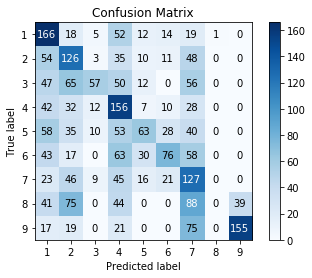

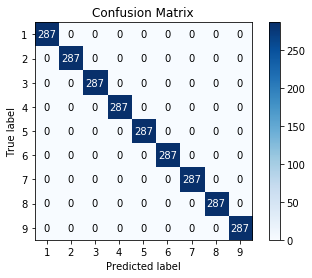

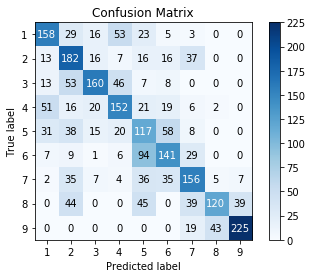

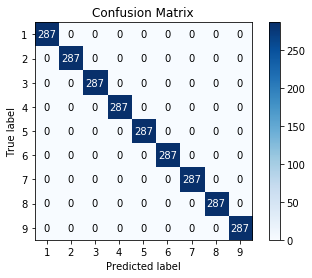

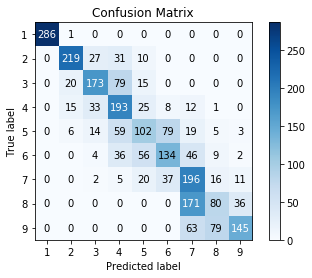

In [319]:

y_true1, y_pred1 = (y_test, model1.predict(X_test))
print('Random Forest')
print(accuracy_score(y_true1, y_pred1))
skplt.plot_confusion_matrix(y_true1, y_pred1)
y_true2, y_pred2 = (y_test, model2.predict(X_test))
print('SVM')
print(accuracy_score(y_true2, y_pred2))
skplt.plot_confusion_matrix(y_true2, y_pred2)
y_true3, y_pred3 = (y_test, model3.predict(X_test))
print('KNN')
print(accuracy_score(y_true3, y_pred3))
skplt.plot_confusion_matrix(y_true3, y_pred3)
y_true4, y_pred4 = (y_test, model4.predict(X_test))
print('Gradient Boost')
print(accuracy_score(y_true4, y_pred4))
skplt.plot_confusion_matrix(y_true4, y_pred4)
y_true5, y_pred5 = (y_test, model5.predict(X_test))
print('Logistic Regression')
print(accuracy_score(y_true5, y_pred5))
skplt.plot_confusion_matrix(y_true5, y_pred5)


In [318]:
#test the three models with the test data and print their accuracy scores
print('rf: {}'.format(model1.score(X_test, y_test)))
print('knn: {}'.format(model3.score(X_test, y_test)))
print('svc: {}'.format(model2.score(X_test, y_test)))
print('gradiant boost: {}'.format(model4.score(X_test, y_test)))
print('log_reg: {}'.format(model5.score(X_test, y_test)))
print('dt: {}'.format(model6.score(X_test, y_test)))

rf: 0.35849787069299266
knn: 0.5462640340689121
svc: 1.0
gradiant boost: 1.0
log_reg: 0.5915602013162988
dt: 1.0
